# **Praktikum 1**

### RNN untuk Analisis Sentimen

#### **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
# Mengimpor pustaka NumPy ke dalam program yang dimana library ini berfungsi untuk komputasi numerik dalam pengolahan data dan array.
import numpy as np

# Mengimpor pustaka TensorFlow Datasets ke dalam program. TensorFlow Datasets adalah pustaka Python untuk mengunduh, memproses, dan mengurutkan kumpulan data untuk digunakan dalam TensorFlow.
import tensorflow_datasets as tfds

# Mengimpor pustaka TensorFlow ke dalam program. TensorFlow adalah pustaka Python untuk pembelajaran mesin dan kecerdasan buatan.
import tensorflow as tf

# Menonaktifkan bilah kemajuan untuk mengunduh kumpulan data TensorFlow Datasets.
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt # Mengimpor pustaka Matplotlib ke dalam program. Matplotlib adalah pustaka Python yang digunakan untuk membuat visualisasi data.

# Digunakan untuk memvisualisasikan riwayat pelatihan model pembelajaran mesin, kemudian membuat dua grafik garis, satu untuk nilai metrik selama pelatihan dan satu untuk nilai metrik validasi. Kedua grafik memiliki label sumbu X yang sama, yaitu "Epochs", dan label sumbu Y yang sama dengan nama metrik yang dipilih.
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets). Lihat [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [ ]:
# Mengambil, membagi, dan menampilkan dataset IMDB dari TensorFlow Datasets beserta informasi tentang struktur elemen dataset pelatihan untuk memahami jenis dan bentuk data.
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
# Mengambil, mencetak teks dan mencetak label satu contoh dari dataset.
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
# Ukuran buffer yang akan digunakan untuk mengacak dataset.
BUFFER_SIZE = 10000

# Ukuran batch yang akan digunakan untuk melatih model.
BATCH_SIZE = 64

# Mengacak dataset untuk mengurangi bias dalam urutan data, lalu membagi dataset menjadi batch dengan ukuran 64 serta mengoptimalkan kinerja input pipeline dengan otomatis memilih jumlah elemen yang akan diprefetch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Membagi dataset tes menjadi batch dengan ukuran 64 dan mengoptimalkan kinerja input pipeline untuk dataset tes.
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mencetak contoh teks dan label dari dataset pelatihan
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This movie bewilders me. It may be that I\'m just a stupid American, but I really just don\'t get 400 Blows. Everything I\'ve read about this movie has been a total rave, but I just couldn\'t stay interested. I\'m sure that it was as revolutionary in film-making as all the critics say, but when it boils right down to it, it\'s just really really boring. Maybe it\'s the language barrier, may I\'m just not "sensitive" or "artsy" enough, but whatever the case is, I hated this movie. The story itself isn\'t bad; it\'s about a young French boy who is treated unfairly by his parents and his teachers, and eventually he ends up in a juvenile facility. That in itself ought to be interesting, and it was, at first. There was nothing wrong with the dialogue, but then again it\'s hard to say because half of the conversations weren\'t subtitled and for no apparent reason, so I didn\'t always know what was going on. But for the dialogue we could understand, it made enough sense. The actors

#### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
# Menentukan ukuran kosakata yang akan digunakan untuk vektorisasi teks. Dalam hal ini, kosakata akan berisi 1000 kata yang paling umum dalam kumpulan data.
VOCAB_SIZE = 1000

# Membuat objek TextVectorization yang akan digunakan untuk mengubah teks menjadi representasi numerik (vektor) dan menentukan ukuran maksimum kosakata yang akan digunakan.
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Mengadaptasi objek TextVectorization untuk menyesuaikan dengan kumpulan data pelatihan.
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
# Mengubah kosakata dari encoder menjadi array NumPy.
vocab = np.array(encoder.get_vocabulary())

# Mengambil 20 kata pertama dari array kosakata.
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
# Mengambil contoh data (example), melakukan encoding terhadapnya menggunakan fungsi encoder, kemudian mengambil 3 elemen pertama dari hasil encoding dan menyimpannya dalam variabel encoded_example. Baris terakhir menampilkan isi dari variabel encoded_example.
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  18,   1, ...,   0,   0,   0],
       [  1,   2, 245, ...,   0,   0,   0],
       [195,  75,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
# Mengulangi proses pencetakan tiga kali untuk menampilkan teks asli dan versi round-trip-nya.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This movie bewilders me. It may be that I\'m just a stupid American, but I really just don\'t get 400 Blows. Everything I\'ve read about this movie has been a total rave, but I just couldn\'t stay interested. I\'m sure that it was as revolutionary in film-making as all the critics say, but when it boils right down to it, it\'s just really really boring. Maybe it\'s the language barrier, may I\'m just not "sensitive" or "artsy" enough, but whatever the case is, I hated this movie. The story itself isn\'t bad; it\'s about a young French boy who is treated unfairly by his parents and his teachers, and eventually he ends up in a juvenile facility. That in itself ought to be interesting, and it was, at first. There was nothing wrong with the dialogue, but then again it\'s hard to say because half of the conversations weren\'t subtitled and for no apparent reason, so I didn\'t always know what was going on. But for the dialogue we could understand, it made enough sense. The acto

#### **Buat Model**

![alt text](bidirectional.png)

###### <center>A drawing of the information flow in the model</center>

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
- Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
- Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
# Membangun model jaringan saraf menggunakan TensorFlow dengan lapisan-lapisan encoder, embedding, bidirectional LSTM layer, dense layer 64 unit, dan dense layer 1 unit.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
# Mencetak daftar nilai Boolean (True atau False) yang menunjukkan apakah setiap layer dalam model mendukung masking.
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

# Mendefinisikan variabel sample_text dengan teks yang ingin dianalisis sentimentnya.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.00316648]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

# Kode ini menggunakan model pembelajaran mesin untuk membuat prediksi berdasarkan sample_text. Untuk memastikan model dapat memproses teks dengan panjang yang berbeda, string padding ditambahkan untuk melengkapi sample_text agar mencapai panjang yang sama dengan teks lain yang mungkin telah digunakan untuk melatih model. Akhirnya, prediksi untuk sample_text dicetak ke layar.
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 108ms/step
[-0.00316648]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
# Mempersiapkan model pembelajaran mesin untuk proses pelatihan dengan menetapkan beberapa konfigurasi penting.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Menentukan fungsi loss yang akan digunakan untuk mengukur seberapa baik model melakukan prediksi
              optimizer=tf.keras.optimizers.Adam(1e-4), # Menentukan algoritma optimasi yang akan digunakan untuk memperbarui bobot model selama pelatihan.
              metrics=['accuracy']) # Menentukan metrik yang akan dilacak dan dilaporkan selama pelatihan.

##### **Train Model**

In [ ]:
# Melatih model pembelajaran mesin menggunakan kumpulan data pelatihan dan mengevaluasinya menggunakan kumpulan data pengujian.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 107ms/step - loss: 0.6509 - accuracy: 0.5506 - val_loss: 0.5004 - val_accuracy: 0.7708
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4181 - accuracy: 0.8080 - val_loss: 0.4035 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3529 - accuracy: 0.8466 - val_loss: 0.3472 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3243 - accuracy: 0.8605 - val_loss: 0.3373 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3134 - accuracy: 0.8658 - val_loss: 0.3347 - val_accuracy: 0.8458
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3075 - accuracy: 0.8688 - val_loss: 0.3238 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 29s 75ms/step - loss: 0.3029 - accuracy: 0.8711 - val_loss: 0.3216 - val_accuracy

In [ ]:
# Mengevaluasi kinerja model pembelajaran mesin pada kumpulan data uji
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 29ms/step - loss: 0.3204 - accuracy: 0.8653
Test Loss: 0.3204367458820343
Test Accuracy: 0.8652799725532532


(0.0, 0.6686655908823014)

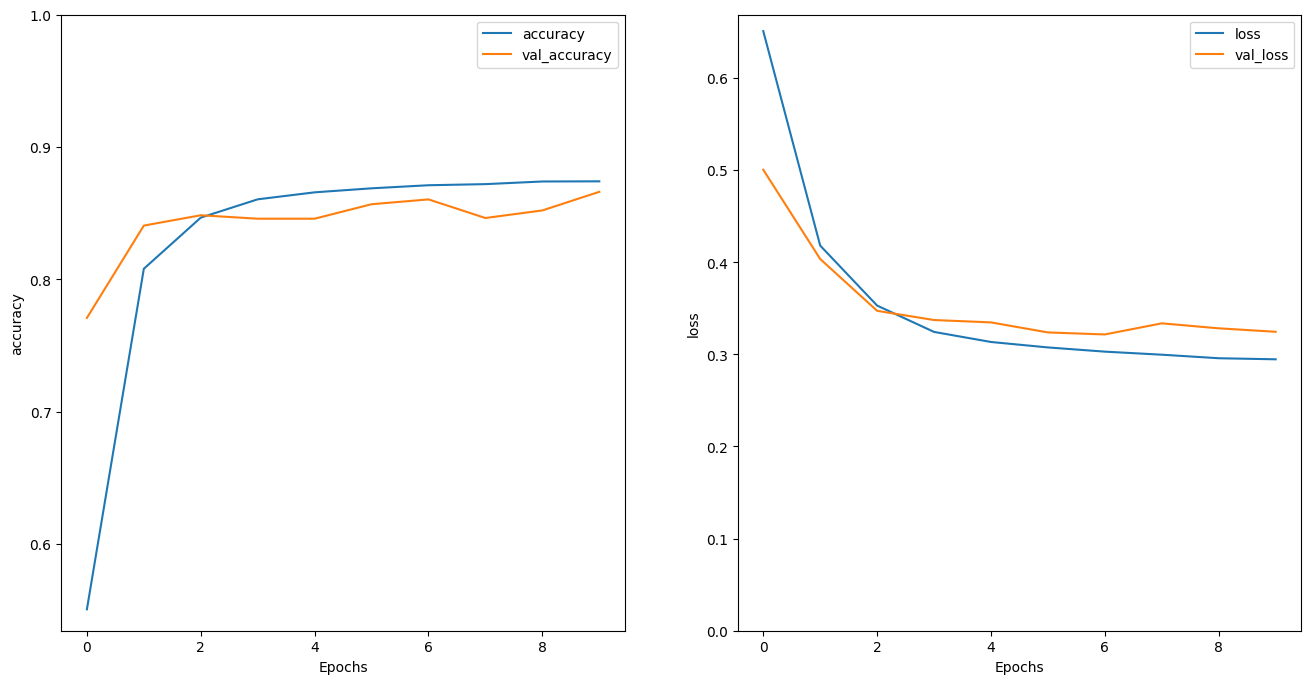

In [ ]:
plt.figure(figsize=(16, 8)) # Membuat gambar baru dengan ukuran yang ditentukan (16 inci lebar dan 8 inci tinggi).
plt.subplot(1, 2, 1) # Membagi gambar menjadi kisi-kisi 1 baris dan 2 kolom, dan memilih subplot pertama (di kiri atas).
plot_graphs(history, 'accuracy') # Memanggil fungsi plot_graphs untuk membuat grafik akurasi.
plt.ylim(None, 1) # Mengatur batas sumbu Y untuk grafik akurasi antara 0 dan 1 (maksimum untuk akurasi).
plt.subplot(1, 2, 2) # Memilih subplot kedua (di kanan atas).
plot_graphs(history, 'loss') # Memanggil fungsi plot_graphs untuk membuat grafik loss.
plt.ylim(0, None) # Mengatur batas sumbu Y untuk grafik loss antara 0 dan tak terbatas (loss tidak memiliki nilai maksimum).

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
# Menyiapkan sebuah teks ulasan film dan kemudian menggunakan model pembelajaran mesin untuk membuat prediksi berdasarkan ulasan
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


#### **Stack two or more LSTM layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

![alt text](bidirectional.png)

###### <center>layered_bidirectional</center>

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
# Membangun model jaringan saraf dengan lapisan embedding, dua lapisan LSTM bidirectional, lapisan fully connected, dan lapisan output.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Mengukur tingkat kesalahan prediksi menggunakan BinaryCrossentropy, memperbarui bobot model menggunakan optimizer Adam untuk meningkatkan prediksi dan memantau akurasi model selama pelatihan untuk mengevaluasi performanya.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Melatih model pembelajaran mesin dengan menggunakan dataset yang diberikan.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 155ms/step - loss: 0.6398 - accuracy: 0.5694 - val_loss: 0.4312 - val_accuracy: 0.8052
Epoch 2/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3872 - accuracy: 0.8313 - val_loss: 0.3500 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3353 - accuracy: 0.8564 - val_loss: 0.3389 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3229 - accuracy: 0.8612 - val_loss: 0.3260 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3158 - accuracy: 0.8640 - val_loss: 0.3250 - val_accuracy: 0.8630
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3081 - accuracy: 0.8671 - val_loss: 0.3238 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3027 - accuracy: 0.8696 - val_loss: 0.3244 - val_ac

In [ ]:
# Mengevaluasi kinerja model pembelajaran mesin pada kumpulan data pengujian.
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3163 - accuracy: 0.8523
Test Loss: 0.31630533933639526
Test Accuracy: 0.8522800207138062


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.6020565]]


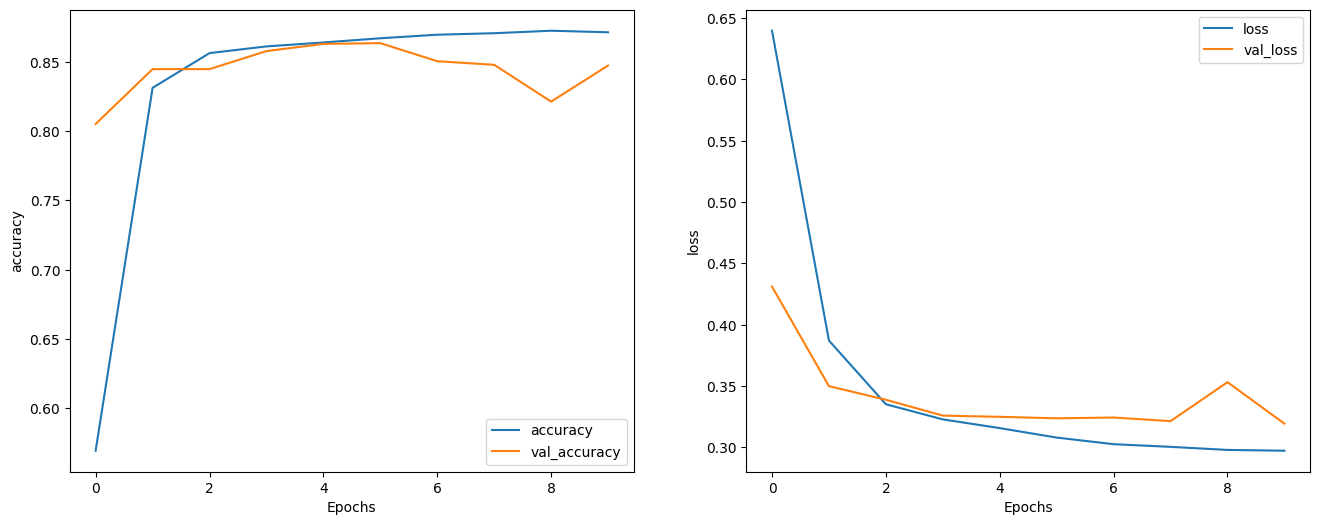

In [ ]:
# Menghasilkan sebuah gambar yang menampilkan dua grafik, grafik pertama (di sebelah kiri) menunjukkan metrik akurasi selama pelatihan dan validasi dan grafik kedua (di sebelah kanan) menunjukkan metrik loss selama pelatihan dan validasi.
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#### **Catatan**
Informasi menarik lain terkait dengan [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

Informasi membuat custom RNN --> [Keras RNN Guide](https://www.tensorflow.org/guide/keras/working_with_rnns).